In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from itertools import product
import plotly.express as px
from scipy.stats import linregress

## Modelagem da Variação Anual dos Dados de Mortalidade

Após testes prévios com modelos lineares, que apresentaram casos de projeção futura de mortalidade negativa, optou-se por criar um modelo exponencial. Vários testes foram realizados com diferentes fórmulas baseadas na base neperiana (número de Euler) elevada a valores negativos e fracionários de mortalidade. Até que se chegou à fórmula adiante

$$
mortalidade = f(ano) = \text{constante} \cdot e^{\text{coeficiente} \cdot (-ano - 1)}
$$

A curva, com seus parâmetros, constante e coeficiente, foi ajustada aos dados com base no biblioteca SciPy - Scientific Python<a name="cite_ref-1"></a>[<sup>[1]</sup>](#cite_note-1). Essa biblioteca ajusta os parâmetros método de Mínimos Quadrados Não Lineares. Esse é um processo que busca a otimização do quadrado dos resíduos (quadrado da diferença entre valores preditos pelo modelo e valores reais). Nesse processo é utilizado o método de Levenberg-Marquardt, que é o mais comumente utilizado em procedimentos para os quais não se apresente restrições aos valores a serem testados iterativamente como parâmetros<a name="cite_ref-2"></a>[<sup>[2]</sup>](#cite_note-2).


<a name="cite_note-1"></a>1. [^](#cite_ref-1) https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

<a name="cite_note-2"></a>2. [^](#cite_ref-2) https://sites.cs.ucsb.edu/~yfwang/courses/cs290i_mvg/pdf/LMA.pdf


# Carregando dados de Óbitos

In [2]:
df_obitos = pd.read_csv('./source/tab/originais/mortalidade segundo sexo e faixa etária.csv', sep=';'
#                             , na_values='-' Linha não implementada, pois todos os valores com "-", indicando valores não apurados foram alterados previamente para 0
#                             , dtype={f'{year}':pd.Int32Dtype for year in range(1996, 2022)}
                                      )

df_obitos = df_obitos[~(df_obitos['Faixa Etária'] == 'Total')]
df_obitos.head()

,Sexo,Faixa Etária,1996,1997,1998,1999,2000,2001,2002,2003,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,Mulheres,Menor 1 ano,512,425,493,449,460,400,365,326,...,239,236,219,221,220,206,181,187,147,139
1,Mulheres,1 a 4 anos,88,99,104,62,66,75,58,75,...,38,34,35,33,37,31,26,35,17,19
2,Mulheres,5 a 9 anos,46,45,53,43,42,30,35,37,...,20,16,15,29,19,24,12,18,9,14
3,Mulheres,10 a 14 anos,58,26,44,40,37,24,45,36,...,31,33,24,23,19,21,18,19,21,24
4,Mulheres,15 a 19 anos,72,90,95,59,73,67,74,75,...,69,76,58,42,52,73,37,41,43,51


In [3]:
for year in df_obitos.columns[2:]:
    for sex in df_obitos.Sexo.unique():
        mortes_idade_ignorada = df_obitos[
            (df_obitos.Sexo == sex) 
            & (df_obitos['Faixa Etária'] =='Idade ignorada')][year].to_numpy()

        total_by_age = df_obitos[
            (df_obitos.Sexo == sex) 
            & (df_obitos['Faixa Etária'] != 'Idade ignorada')
            ][year].sum()

        unmarked_deaths_redistributed = (
            df_obitos[
                (df_obitos.Sexo == sex) 
                & (df_obitos['Faixa Etária'] != 'Idade ignorada')
                ][year].to_numpy() * 1/total_by_age * mortes_idade_ignorada
            ).round().astype(int)
        
        treated_values = (
            df_obitos[
                (df_obitos.Sexo == sex) 
                & (df_obitos['Faixa Etária'] != 'Idade ignorada')
                ][year] + unmarked_deaths_redistributed).to_numpy()
        
        df_obitos.loc[((df_obitos.Sexo == sex) & (df_obitos['Faixa Etária'] != 'Idade ignorada')), year]  = treated_values  # = treated_values

df_obitos = df_obitos.loc[df_obitos['Faixa Etária'] != 'Idade ignorada',:]

df_obitos.set_index(['Sexo', 'Faixa Etária'],inplace=True)
df_obitos.columns = [int(column) for column in df_obitos.columns]

In [4]:
df_obitos.columns

Index([1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007,
       2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019,
       2020, 2021],
      dtype='int64')

In [5]:

df_obitos.head()

1996  1997  1998  1999  2000  2001  2002  2003  2004  \
Sexo     Faixa Etária                                                         
Mulheres Menor 1 ano    514   426   495   450   461   400   365   326   302   
         1 a 4 anos      88    99   104    62    66    75    58    75    46   
         5 a 9 anos      46    45    53    43    42    30    35    37    34   
         10 a 14 anos    58    26    44    40    37    24    45    36    29   
         15 a 19 anos    72    90    95    59    73    67    74    75    72   

                       2005  ...  2012  2013  2014  2015  2016  2017  2018  \
Sexo     Faixa Etária        ...                                             
Mulheres Menor 1 ano    290  ...   239   236   219   221   220   206   181   
         1 a 4 anos      67  ...    38    34    35    33    37    31    26   
         5 a 9 anos      35  ...    20    16    15    29    19    24    12   
         10 a 14 anos    34  ...    31    33    24    23    19    21    18   
         15 a 19 anos    79  ...    69    76    58    42    52    73    37   

                       2019  2020  2021  
Sexo     Faixa Etária                    
Mulheres Menor 1 ano    187   147   139  
         1 a 4 anos      35    17    19  
         5 a 9 anos      18     9    14  
         10 a 14 anos    19    21    24  
         15 a 19 anos    41    43    51  

[5 rows x 26 columns]

## Carregando dados de População 1996 a 2022

In [6]:
df_pop_1996_2022 = pd.read_csv('./source/tab/originais/pop 1996 a 2022.csv'
                               ,sep=';'
                               , usecols=['Faixa Etária', 'Sexo', '1996', '2000', '2010', '2022']
                               ,index_col=['Sexo', 'Faixa Etária']
                               )
df_pop_1996_2022.columns = [1996, 2000, 2010, 2022]
df_pop_1996_2022.head()


1996    2000    2010    2022
Sexo     Faixa Etária                                
Mulheres Menor 1 ano    24127   25789   21664   22722
         1 a 4 anos     94310  102495   88000   96868
         5 a 9 anos    119490  127219  114907  117868
         10 a 14 anos  125912  128334  133976  114922
         15 a 19 anos  130233  139027  136653  123448

In [7]:
df_taxa_crecimento_pop = pd.DataFrame()
df_taxa_crecimento_pop['1996 a 2000'] = (df_pop_1996_2022[2000] / df_pop_1996_2022[1996])**(1/(2000-1996)) - 1
df_taxa_crecimento_pop['2000 a 2010'] = (df_pop_1996_2022[2010] / df_pop_1996_2022[2000])**(1/(2010-2000)) - 1
df_taxa_crecimento_pop['2010 a 2022'] = (df_pop_1996_2022[2022] / df_pop_1996_2022[2010])**(1/(2022-2010)) - 1


In [8]:
for taxa in df_taxa_crecimento_pop.columns:
    ano_inicial, ano_final = [int(ano.strip()) for ano in taxa.split('a')]
    
    for ano in range(ano_inicial, ano_final):

        df_pop_1996_2022[ano] = (df_pop_1996_2022[ano_inicial]*((1+ df_taxa_crecimento_pop[taxa])**(ano-ano_inicial))).astype(int)

df_pop_1996_2022 = df_pop_1996_2022[range(df_pop_1996_2022.columns.min(), df_pop_1996_2022.columns.max()+1)]

In [9]:
df_mortalidade = (df_obitos / df_pop_1996_2022.iloc[:,:-1] * 1000).round(2)

In [10]:
custom_order = ['Menor 1 ano', '1 a 4 anos', '5 a 9 anos', '10 a 14 anos'
         ,'15 a 19 anos', '20 a 29 anos', '30 a 39 anos', '40 a 49 anos'
         ,'50 a 59 anos', '60 a 69 anos', '70 a 79 anos', '80 anos e mais']

#df_mortalidade.index = pd.Categorical(df_mortalidade.index, categories=custom_order, ordered=True)

#df_mortalida = df_mortalidade.sort_index()

In [11]:
df_mortalidade.head()

1996   1997   1998   1999   2000   2001   2002   2003  \
Sexo     Faixa Etária                                                           
Mulheres Menor 1 ano   21.30  17.37  19.84  17.74  17.88  15.78  14.66  13.32   
         1 a 4 anos     0.93   1.03   1.06   0.62   0.64   0.74   0.58   0.77   
         5 a 9 anos     0.38   0.37   0.43   0.34   0.33   0.24   0.28   0.30   
         10 a 14 anos   0.46   0.21   0.35   0.31   0.29   0.19   0.35   0.28   
         15 a 19 anos   0.55   0.68   0.71   0.43   0.53   0.48   0.53   0.54   

                        2004   2005  ...   2012   2013  2014   2015  2016  \
Sexo     Faixa Etária                ...                                    
Mulheres Menor 1 ano   12.56  12.27  ...  10.95  10.76  9.95  10.00  9.92   
         1 a 4 anos     0.48   0.71  ...   0.42   0.38  0.39   0.36  0.40   
         5 a 9 anos     0.28   0.29  ...   0.17   0.14  0.13   0.25  0.16   
         10 a 14 anos   0.22   0.26  ...   0.24   0.26  0.19   0.18  0.15   
         15 a 19 anos   0.52   0.57  ...   0.51   0.57  0.44   0.32  0.40   

                       2017  2018  2019  2020  2021  
Sexo     Faixa Etária                                
Mulheres Menor 1 ano   9.25  8.09  8.33  6.52  6.14  
         1 a 4 anos    0.33  0.28  0.37  0.18  0.20  
         5 a 9 anos    0.21  0.10  0.15  0.08  0.12  
         10 a 14 anos  0.17  0.15  0.16  0.18  0.21  
         15 a 19 anos  0.57  0.29  0.32  0.34  0.41  

[5 rows x 26 columns]

In [12]:
df_mortalidade.reset_index().set_index(['Sexo']).groupby(['Faixa Etária']).sum()

,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
Faixa Etária,,,,,,,,,,,,,,,,,,,,,
1 a 4 anos,1.93,2.05,2.05,1.51,1.57,1.57,1.28,1.47,1.27,1.28,...,0.92,0.88,0.72,0.70,0.84,0.71,0.78,0.83,0.43,0.49
10 a 14 anos,1.17,0.82,0.77,0.74,0.73,0.70,0.79,0.68,0.62,0.72,...,0.62,0.71,0.52,0.44,0.46,0.39,0.40,0.35,0.40,0.44
15 a 19 anos,2.30,2.41,2.40,2.15,2.65,2.18,2.54,2.68,2.94,3.42,...,2.84,2.91,2.73,2.48,2.65,2.21,1.82,1.83,1.56,1.56
20 a 29 anos,3.91,3.84,3.34,3.52,3.26,3.41,3.45,3.63,3.80,3.99,...,3.71,3.25,3.41,3.36,3.32,2.82,2.74,2.57,2.88,3.54
30 a 39 anos,5.66,5.68,5.25,4.89,4.68,4.58,4.40,4.47,4.74,4.52,...,4.41,4.31,4.14,3.69,3.84,3.66,3.51,3.21,3.97,6.04
40 a 49 anos,10.19,9.93,10.48,9.25,9.20,8.36,8.57,8.84,8.49,8.20,...,6.86,7.10,6.59,6.55,6.41,5.80,5.84,5.51,6.56,11.58
5 a 9 anos,0.90,0.85,0.82,0.72,0.83,0.54,0.74,0.76,0.56,0.73,...,0.36,0.38,0.31,0.44,0.33,0.37,0.23,0.30,0.23,0.27
50 a 59 anos,22.97,21.28,21.98,21.43,20.00,18.90,19.23,18.77,18.97,17.27,...,14.80,14.83,13.94,14.47,14.28,13.28,13.15,12.72,15.60,25.74
60 a 69 anos,53.90,53.26,51.09,51.24,48.00,45.55,44.19,42.71,42.06,38.65,...,32.86,33.31,31.84,31.23,32.36,30.06,30.27,29.51,36.38,47.55


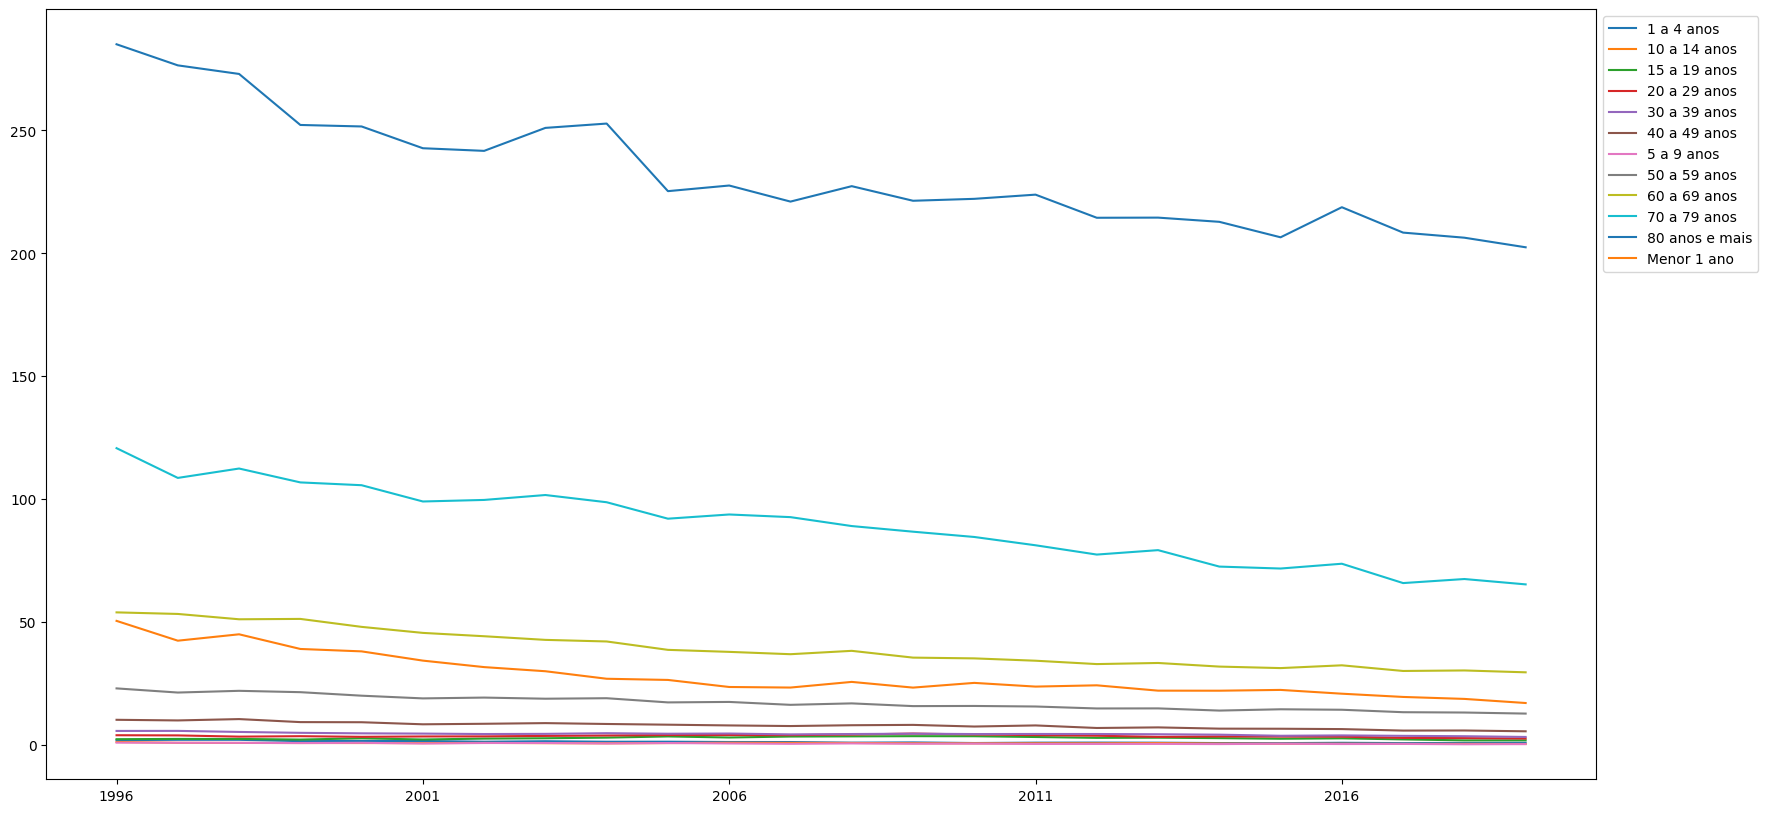

In [13]:
df_mortalidade.reset_index().set_index(['Sexo']).groupby(['Faixa Etária']).sum().transpose().iloc[:-2].plot(kind='line', figsize=(20,10))
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

In [14]:
df_mortalidade.drop(columns=[2020,2021], inplace=True)

In [15]:
df_mortalidade.reset_index(inplace=True)

In [16]:
df_mortalidade[(df_mortalidade['Faixa Etária'] == '40 a 49 anos') & (df_mortalidade['Sexo'] == 'Mulheres')].iloc[:,2:].values

array([[3.34, 3.32, 3.68, 2.95, 2.91, 2.73, 2.82, 2.81, 2.46, 2.48, 2.46,
        2.28, 2.46, 2.5 , 2.33, 2.47, 2.19, 2.37, 2.  , 2.16, 2.05, 2.02,
        1.92, 1.91]])

In [17]:
df_mortalidade[(df_mortalidade['Faixa Etária'] == '40 a 49 anos') & (df_mortalidade['Sexo'] == 'Mulheres')].iloc[:,2:].columns

Index([1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007,
       2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019],
      dtype='object')

In [18]:
results = []

faixas_etarias = df_mortalidade['Faixa Etária'].unique()
sexos = df_mortalidade['Sexo'].unique()


for faixa_etaria, sexo in product(faixas_etarias, sexos):

    
    # Realizar a regressão linear
    x = np.array(df_mortalidade[(df_mortalidade['Faixa Etária'] == faixa_etaria) & (df_mortalidade['Sexo'] == sexo)].iloc[:,2:].columns, dtype=int)
    y = df_mortalidade[(df_mortalidade['Faixa Etária'] == faixa_etaria) & (df_mortalidade['Sexo'] == sexo)].iloc[:,2:].values

    
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    
    # Armazenar os resultados em um dicionário
    result_dict = {
        'Sexo':sexo,
        'Faixa Etária': faixa_etaria,
        'Slope': slope,
        'Intercept': intercept,
        'R-squared (r_value)': r_value**2,
        'p-value': p_value,
        'Std. Error': std_err
    }
    
    results.append(result_dict)

# Criar um DataFrame a partir da lista de resultados
df_model_results = pd.DataFrame(results)

# Exibir o DataFrame com os resultados
df_model_results


,Sexo,Faixa Etária,Slope,Intercept,R-squared (r_value),p-value,Std. Error
0,Mulheres,Menor 1 ano,-0.476070,968.469652,0.833714,4.910952e-10,0.045329
1,Homens,Menor 1 ano,-0.670848,1362.104928,0.807916,2.433974e-09,0.069739
2,Mulheres,1 a 4 anos,-0.027613,55.975268,0.742846,6.257537e-08,0.003464
3,Homens,1 a 4 anos,-0.028209,57.260623,0.844699,2.301995e-10,0.002579
4,Mulheres,5 a 9 anos,-0.010917,22.157913,0.740657,6.878078e-08,0.001377
5,Homens,5 a 9 anos,-0.015657,31.732551,0.809589,2.208507e-09,0.001619
6,Mulheres,10 a 14 anos,-0.007809,15.924290,0.521225,6.813406e-05,0.001596
7,Homens,10 a 14 anos,-0.013443,27.403616,0.634066,3.252658e-06,0.002177
8,Mulheres,15 a 19 anos,-0.008543,17.666449,0.303036,5.313665e-03,0.002762
9,Homens,15 a 19 anos,0.006648,-11.145094,0.009942,6.429714e-01,0.014144


In [19]:
-0.476070 * 2030 + 968.469652

2.047551999999996

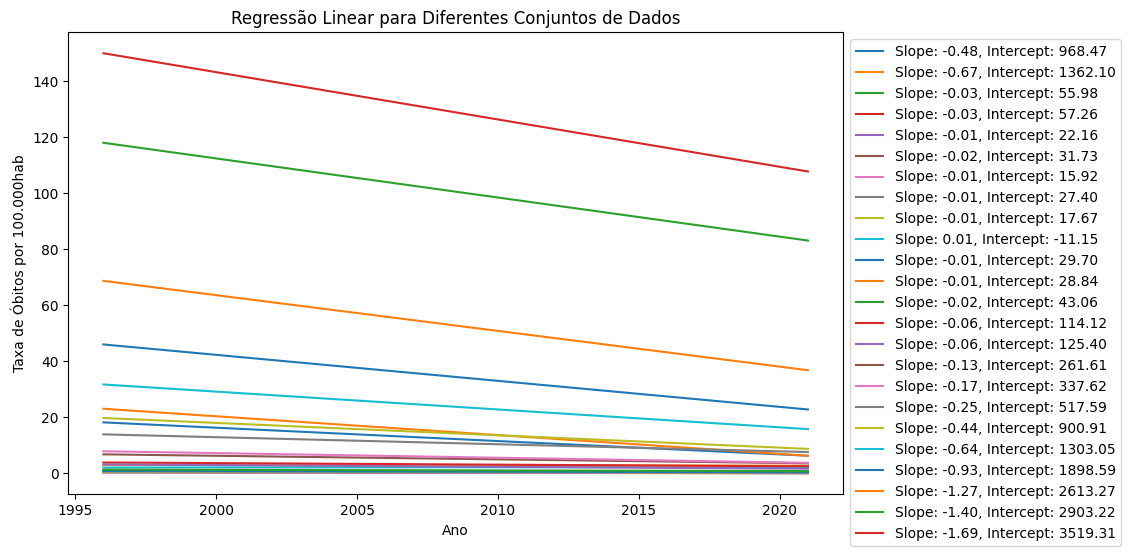

In [20]:
# Suponha que você tenha um intervalo de anos para a plotagem
anos = np.arange(1996, 2022)

# Crie um novo gráfico
plt.figure(figsize=(10, 6))

# Itere sobre cada par de slope e intercept
for slope, intercept in zip(df_model_results.Slope, df_model_results.Intercept):
    # Calcule os valores previstos (y) com base na reta de regressão
    y_pred = slope * anos + intercept
    
    # Plote a reta de regressão
    plt.plot(anos, y_pred, label=f'Slope: {slope:.2f}, Intercept: {intercept:.2f}')

# Adicione rótulos e legenda
plt.xlabel('Ano')
plt.ylabel('Taxa de Óbitos por 100.000hab')
plt.title('Regressão Linear para Diferentes Conjuntos de Dados')

plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Exiba o gráfico
plt.show()


In [21]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [22]:
np.array(df_mortalidade.columns[2:], dtype=int)
df_mortalidade.iloc[0,2:].values.astype(float)

array([21.3 , 17.37, 19.84, 17.74, 17.88, 15.78, 14.66, 13.32, 12.56,
       12.27, 10.29, 10.56, 11.68, 10.8 , 11.68, 11.26, 10.95, 10.76,
        9.95, 10.  ,  9.92,  9.25,  8.09,  8.33])

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import statsmodels.api as sm

# Dados de exemplo (substitua pelos seus dados reais)
#anos = np.arange(1996, 2021)
#taxa_de_obitos = [100, 90, 80, 70, 60, 50, 40, 30, 20, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4]


anos = np.array(df_mortalidade.columns[2:], dtype=int)
taxa_de_obitos = df_mortalidade.iloc[0,2:].values.astype(float)

# Função para a fórmula c + b * a ** x
#def modelo(x, c, b, a):
#    return c + b * a ** x

def modelo(x, a, b, c):
    return a * np.exp(-b * x) + c

# Ajuste do modelo aos dados
params, covariance = curve_fit(modelo, anos, taxa_de_obitos)

# Parâmetros ajustados
c, b, a = params

# Análise de resíduos com statsmodels
#X = sm.add_constant(anos)  # Variável independente (ano)

y = taxa_de_obitos  # Variável dependente (taxa de óbitos)
modelo_statsmodels = sm.OLS(y - modelo(anos, c, b, a), X).fit()

# Resumo do modelo
print(modelo_statsmodels.summary())

# Plotagem dos resíduos
plt.figure(figsize=(10, 6))
plt.scatter(anos, modelo_statsmodels.resid, label='Resíduos', marker='o')
plt.axhline(y=0, color='red', linestyle='--', label='Linha de 0')
plt.xlabel('Ano')
plt.ylabel('Resíduos')
plt.title('Análise de Resíduos')
plt.legend()
plt.grid(True)
plt.show()


/home/augustogeog/development/playground/.venv/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


NameError: name 'X' is not defined

In [ ]:
x

array([1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006,
       2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
       2018, 2019])

In [ ]:
y

array([21.3 , 17.37, 19.84, 17.74, 17.88, 15.78, 14.66, 13.32, 12.56,
       12.27, 10.29, 10.56, 11.68, 10.8 , 11.68, 11.26, 10.95, 10.76,
        9.95, 10.  ,  9.92,  9.25,  8.09,  8.33])

In [ ]:
(a*-10) * np.exp(-b*0.001 * x) + 8

array([-9.3379956 , -9.32066627, -9.30335427, -9.28605956, -9.26878214,
       -9.25152199, -9.23427909, -9.21705343, -9.19984498, -9.18265373,
       -9.16547967, -9.14832277, -9.13118301, -9.11406039, -9.09695489,
       -9.07986648, -9.06279515, -9.04574088, -9.02870366, -9.01168347,
       -8.99468029, -8.9776941 , -8.9607249 , -8.94377265])

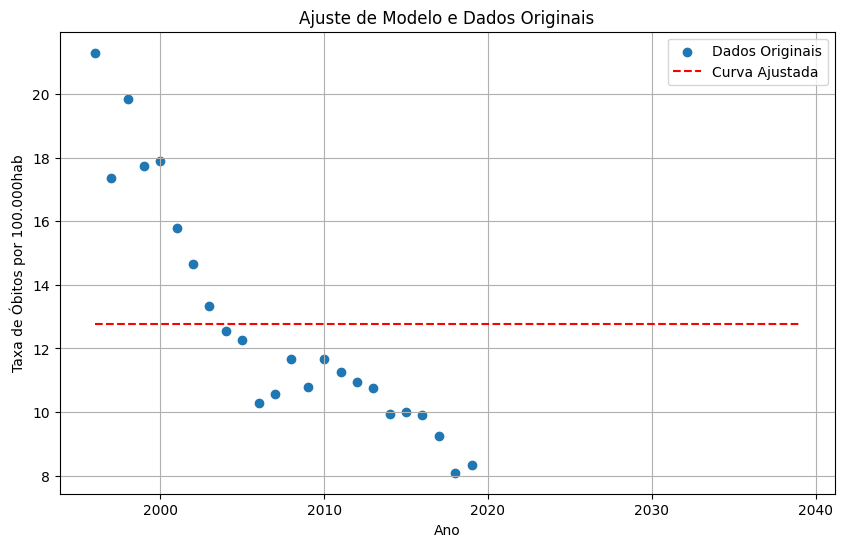

In [ ]:
anos_futuros = np.arange(1996, 2040)
previsao = modelo(anos_futuros, c, b, a)

plt.figure(figsize=(10, 6))
plt.scatter(anos, taxa_de_obitos, label='Dados Originais', marker='o')
plt.plot(anos_futuros, previsao, label='Curva Ajustada', linestyle='--', color='red')
plt.xlabel('Ano')
plt.ylabel('Taxa de Óbitos por 100.000hab')
plt.title('Ajuste de Modelo e Dados Originais')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
a * np.exp(-b * x) + c

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1.])

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Dados de exemplo (substitua pelos seus dados reais)
anos = np.arange(1996, 2022)
taxa_de_obitos = [100, 90, 80, 70, 60, 50, 40, 30, 20, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4]

# Criando um DataFrame com os dados
df = pd.DataFrame({'Ano': anos, 'Taxa de Óbitos por 100.000hab': taxa_de_obitos})

# Ajuste do modelo de regressão exponencial decrescente
X = sm.add_constant(df['Ano'])  # Variável independente (ano)
y = df['Taxa de Óbitos por 100.000hab']  # Variável dependente (taxa de óbitos)

# Definindo a fórmula para o modelo
formula = 'y ~ aAno)'

# Ajustando o modelo com a fórmula
modelo = sm.OLS.from_formula(formula, data=df).fit()

# Previsões do modelo para anos futuros
anos_futuros = np.arange(1996, 2040)
df_futuro = pd.DataFrame({'Ano': anos_futuros})
previsao_log = modelo.predict(df_futuro)
previsao = np.exp(previsao_log)

# Plotagem dos dados e da previsão
plt.figure(figsize=(10, 6))
plt.scatter(anos, taxa_de_obitos, label='Dados reais', marker='o')
plt.plot(anos_futuros, previsao, label='Previsão (Modelo Exponencial Decrescente)', linestyle='--', color='red')
plt.xlabel('Ano')
plt.ylabel('Taxa de Óbitos por 100.000hab')
plt.title('Modelo Exponencial Decrescente para Comportamento Decrescente')
plt.legend()
plt.grid(True)
plt.show()

# Resumo do modelo
print(modelo.summary())


ValueError: All arrays must be of the same length

In [ ]:
x - 1996

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

In [ ]:
np.log(np.array(df_mortalidade.columns[2:], dtype=int))

array([7.59890046, 7.59940133, 7.59990196, 7.60040233, 7.60090246,
       7.60140233, 7.60190196, 7.60240134, 7.60290046, 7.60339934,
       7.60389797, 7.60439635, 7.60489448, 7.60539236, 7.60589   ,
       7.60638739, 7.60688453, 7.60738143, 7.60787807, 7.60837447,
       7.60887063, 7.60936654, 7.6098622 , 7.61035762])

In [60]:
fit = np.polyfit(np.log(np.array(df_mortalidade.columns[2:], dtype=int)), np.log(df_mortalidade.iloc[0,2:].values.astype(float)), 1)

In [67]:
np.array(df_mortalidade.columns[2:], dtype=int)[0]

1996

In [73]:
fit[1]**7

1.5487057116779366e+19

In [71]:
np.log(np.array(df_mortalidade.columns[2:], dtype=int)[0])

7.59890045687141

In [70]:
fit[0]+np.e**(fit[1]**np.log(np.array(df_mortalidade.columns[2:], dtype=int)[0]))

/tmp/ipykernel_12667/3772574930.py:1: RuntimeWarning: overflow encountered in scalar power
  fit[0]+np.e**(fit[1]**np.log(np.array(df_mortalidade.columns[2:], dtype=int)[0]))


inf

In [61]:
ln(y) = 0.9817 + 0.2041(x)

array([-72.17121478, 551.34587362])

In [55]:
def func(x, a, b, c):
#    return (a-c) * np.exp(-x/b) + c

#    return a*np.e**(-x/b)+c

    return a*(b**(-1*x)) + c

xdata = np.log(np.array(df_mortalidade.columns[2:], dtype=int))
ydata = df_mortalidade.iloc[0,2:].values.astype(float)



#xdata = np.linspace(0, 4, 50)
#y = func(xdata, 2.5, 1.3, 0.5)
rng = np.random.default_rng()
#y_noise = 0.2 * rng.normal(size=xdata.size)
#ydata = y + y_noise

In [56]:
lb = [0,0,0]
ub = [10000,100,3]
popt, pcov = curve_fit(func, xdata, ydata, p0=(1400,1.8,0.9), maxfev=10000000
                       , bounds=(lb, ub)
                       )
popt

array([1.00000000e+04, 2.40181528e+00, 7.51182805e-13])

In [57]:
popt

array([1.00000000e+04, 2.40181528e+00, 7.51182805e-13])

In [58]:
popt[0]* popt[1]**(-1*xdata)+ popt[2]

array([12.83268205, 12.82705127, 12.82142578, 12.81580557, 12.81019064,
       12.80458096, 12.79897655, 12.79337738, 12.78778346, 12.78219477,
       12.77661131, 12.77103307, 12.76546004, 12.75989222, 12.75432959,
       12.74877216, 12.74321991, 12.73767283, 12.73213092, 12.72659417,
       12.72106257, 12.71553612, 12.7100148 , 12.70449862])

In [30]:
#popt, pcov = curve_fit(func, xdata, ydata, bounds=(0, [3., 1., 0.5]))
#popt

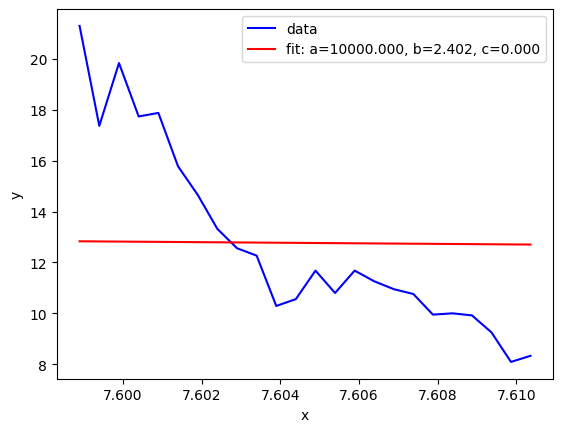

In [59]:
plt.plot(xdata, ydata, 'b-', label='data')
plt.plot(xdata, func(xdata, *popt), 'r-',
         label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt)
         )
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

/home/augustogeog/development/playground/.venv/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


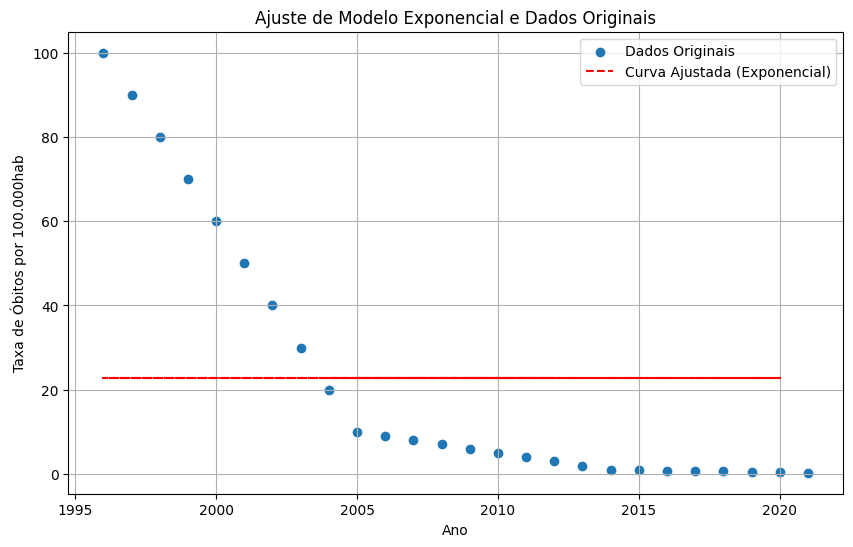

In [ ]:
from sklearn.base import BaseEstimator, RegressorMixin
import numpy as np

class ExponentialModel(BaseEstimator, RegressorMixin):
    def __init__(self):
        pass

    def fit(self, X, y):
        # Ajustar o modelo usando a função func
        from scipy.optimize import curve_fit
        params, _ = curve_fit(func, X.ravel(), y)
        self.a_, self.b_, self.c_ = params
        return self

    def predict(self, X):
        # Usar a função func para fazer previsões
        return func(X.ravel(), self.a_, self.b_, self.c_)

# Exemplo de uso
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Dados de exemplo (substitua pelos seus dados reais)
X = np.arange(1996, 2022).reshape(-1, 1)
y = [100, 90, 80, 70, 60, 50, 40, 30, 20, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3]

# Divisão em conjunto de treinamento e teste (apenas para exemplo)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crie e ajuste o modelo exponencial personalizado
modelo = ExponentialModel()
modelo.fit(X_train, y_train)

# Previsões do modelo para o conjunto de teste
y_pred = modelo.predict(X_test)

# Plotagem dos dados originais e da curva ajustada
plt.figure(figsize=(10, 6))
plt.scatter(X, y, label='Dados Originais', marker='o')
plt.plot(X_test, y_pred, label='Curva Ajustada (Exponencial)', linestyle='--', color='red')
plt.xlabel('Ano')
plt.ylabel('Taxa de Óbitos por 100.000hab')
plt.title('Ajuste de Modelo Exponencial e Dados Originais')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
df_obitos.reset_index()['Faixa Etária'].unique()

array(['Menor 1 ano', '1 a 4 anos', '5 a 9 anos', '10 a 14 anos',
       '15 a 19 anos', '20 a 29 anos', '30 a 39 anos', '40 a 49 anos',
       '50 a 59 anos', '60 a 69 anos', '70 a 79 anos', '80 anos e mais'],
      dtype=object)

In [ ]:
df_obitos.reset_index()[df_obitos['Faixa Etária'].isin()]

,Sexo,Faixa Etária,1996,1997,1998,1999,2000,2001,2002,2003,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,Mulheres,Menor 1 ano,514,426,495,450,461,400,365,326,...,239,236,219,221,220,206,181,187,147,139
1,Mulheres,1 a 4 anos,88,99,104,62,66,75,58,75,...,38,34,35,33,37,31,26,35,17,19
2,Mulheres,5 a 9 anos,46,45,53,43,42,30,35,37,...,20,16,15,29,19,24,12,18,9,14
3,Mulheres,10 a 14 anos,58,26,44,40,37,24,45,36,...,31,33,24,23,19,21,18,19,21,24
4,Mulheres,15 a 19 anos,72,90,95,59,73,67,74,75,...,69,76,58,42,52,73,37,41,43,51
5,Mulheres,20 a 29 anos,216,206,199,205,188,187,173,174,...,168,135,173,165,149,128,134,145,177,250
6,Mulheres,30 a 39 anos,278,331,317,331,306,285,298,297,...,315,297,262,268,286,270,267,259,290,494
7,Mulheres,40 a 49 anos,493,515,598,504,523,503,534,546,...,527,576,492,537,515,513,492,495,579,1064
8,Mulheres,50 a 59 anos,720,715,771,812,802,804,876,807,...,939,974,883,971,969,956,936,943,1113,1982
9,Mulheres,60 a 69 anos,1240,1227,1208,1231,1216,1196,1207,1219,...,1343,1386,1408,1391,1510,1529,1580,1506,1964,2842


<Axes: >

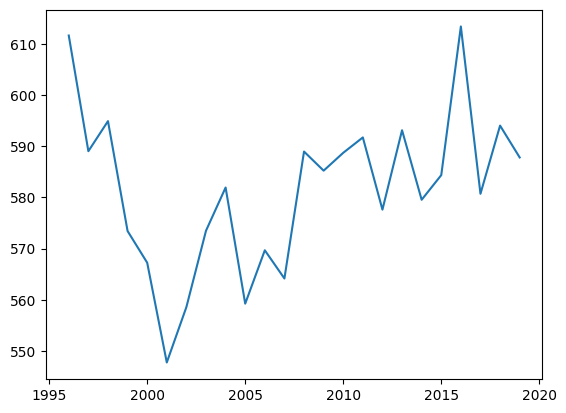

In [ ]:
(df_obitos.sum()[:-2] / df_pop_1996_2022.sum()[:-3] * 100_000).plot(kind='line')

In [ ]:
df_obitos.sum()[:-2]

1996    15378
1997    15227
1998    15816
1999    15681
2000    15959
2001    15598
2002    16106
2003    16749
2004    17220
2005    16772
2006    17322
2007    17398
2008    18428
2009    18584
2010    18980
2011    19209
2012    18885
2013    19536
2014    19234
2015    19547
2016    20686
2017    19747
2018    20375
2019    20341
dtype: int64

In [ ]:
df_mortalidade

,Sexo,Faixa Etária,1996,1997,1998,1999,2000,2001,2002,2003,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Mulheres,Menor 1 ano,21.30,17.37,19.84,17.74,17.88,15.78,14.66,13.32,...,11.68,11.26,10.95,10.76,9.95,10.00,9.92,9.25,8.09,8.33
1,Mulheres,1 a 4 anos,0.93,1.03,1.06,0.62,0.64,0.74,0.58,0.77,...,0.30,0.36,0.42,0.38,0.39,0.36,0.40,0.33,0.28,0.37
2,Mulheres,5 a 9 anos,0.38,0.37,0.43,0.34,0.33,0.24,0.28,0.30,...,0.22,0.14,0.17,0.14,0.13,0.25,0.16,0.21,0.10,0.15
3,Mulheres,10 a 14 anos,0.46,0.21,0.35,0.31,0.29,0.19,0.35,0.28,...,0.19,0.21,0.24,0.26,0.19,0.18,0.15,0.17,0.15,0.16
4,Mulheres,15 a 19 anos,0.55,0.68,0.71,0.43,0.53,0.48,0.53,0.54,...,0.67,0.49,0.51,0.57,0.44,0.32,0.40,0.57,0.29,0.32
5,Mulheres,20 a 29 anos,0.89,0.83,0.78,0.78,0.70,0.69,0.63,0.63,...,0.66,0.64,0.57,0.46,0.59,0.57,0.52,0.45,0.47,0.51
6,Mulheres,30 a 39 anos,1.31,1.51,1.41,1.43,1.29,1.18,1.22,1.20,...,1.06,0.97,1.15,1.08,0.95,0.97,1.03,0.97,0.96,0.93
7,Mulheres,40 a 49 anos,3.34,3.32,3.68,2.95,2.91,2.73,2.82,2.81,...,2.33,2.47,2.19,2.37,2.00,2.16,2.05,2.02,1.92,1.91
8,Mulheres,50 a 59 anos,8.23,7.74,7.90,7.87,7.36,7.04,7.32,6.43,...,5.11,5.31,5.16,5.24,4.66,5.02,4.90,4.74,4.54,4.48
9,Mulheres,60 a 69 anos,21.39,20.43,19.41,19.08,18.19,17.18,16.64,16.13,...,13.75,13.10,12.28,12.15,11.83,11.21,11.66,11.32,11.22,10.25


In [ ]:
df_mortalidade.reset_index().set_index(['Sexo']).groupby(['Faixa Etária']).sum().transpose().iloc[:-2].mean()

Faixa Etária
1 a 4 anos          1.763478
10 a 14 anos        1.443043
15 a 19 anos        3.544783
20 a 29 anos        4.473913
30 a 39 anos        5.370870
40 a 49 anos        8.861739
5 a 9 anos          1.239565
50 a 59 anos       17.921304
60 a 69 anos       39.572609
70 a 79 anos       88.936957
80 anos e mais    226.290870
Menor 1 ano        28.330435
dtype: float64

In [ ]:
np.log(df_mortalidade.columns[2:].astype(int))

Index([  7.59890045687141,  7.599401333415815,  7.599901959208498,
          7.6004023345004,  7.600902459542082,  7.601402334583733,
        7.601901959875166,  7.602401335665818,  7.602900462204755,
         7.60339933974067,  7.603897968521881,  7.604396348796338,
         7.60489448081162,  7.605392364814935,  7.605890001053122,
        7.606387389772652,   7.60688453121963,  7.607381425639791,
        7.607878073278507,  7.608374474380783,   7.60887062919126,
       7.6093665379542115,  7.609862200913554,  7.610357618312838],
      dtype='float64')

In [ ]:
df_mortalidade.reset_index().set_index(['Sexo']).groupby(['Faixa Etária']).sum().transpose().iloc[1:, 11:12]

Faixa Etária,Menor 1 ano
1996,50.44
1997,42.38
1998,44.98
1999,39.01
2000,38.03
2001,34.27
2002,31.63
2003,29.95
2004,26.89
2005,26.41


In [ ]:
np.array([2.71828182846])**np.array([2])

array([7.3890561])

/tmp/ipykernel_12667/1917371957.py:12: RuntimeWarning: overflow encountered in exp
  return constante * np.exp(coeficiente * (-x - 1))


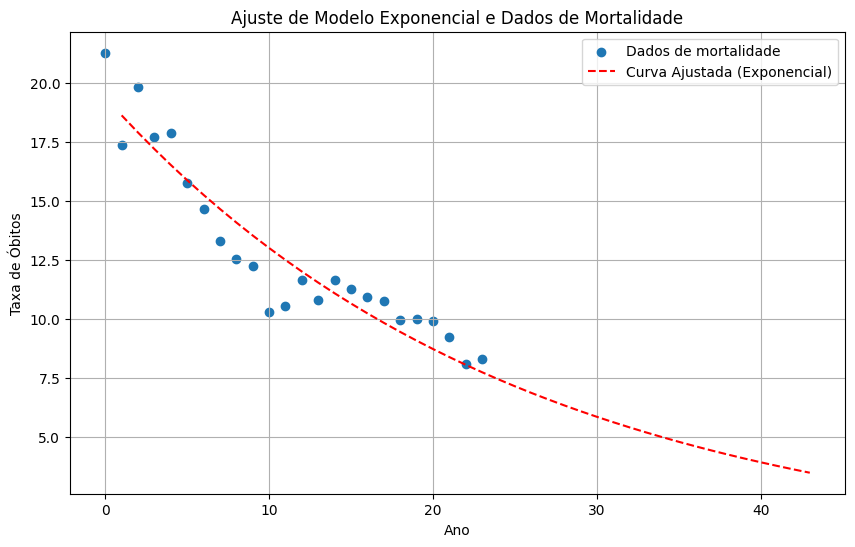

Constante: 20.192926197425802
Coeficiente: 0.03989893558294258


In [98]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Gerar dados de exemplo
#anos = np.arange(1996, 2020)
# Gere dados de mortalidade decrescentes de maneira exponencial
#dados_mortalidade = np.exp(-0.1 * (anos - 1996)) + np.random.normal(0, 0.05, len(anos))

# Defina a função exponencial decrescente
def modelo_exponencial(x, constante, coeficiente):
    return constante * np.exp(coeficiente * (-x - 1))

# Ajuste o modelo exponencial aos dados
params, covariance = curve_fit(modelo_exponencial, anos, dados_mortalidade, maxfev=10000)

# Parâmetros ajustados
constante, coeficiente = params

# Calcule as previsões do modelo para os anos
anos_futuros = np.arange(1, 44)
previsao = modelo_exponencial(anos_futuros, constante, coeficiente)

# Plotagem dos dados e da curva ajustada
plt.figure(figsize=(10, 6))
plt.scatter(anos, dados_mortalidade, label='Dados de mortalidade', marker='o')
plt.plot(anos_futuros, previsao, label='Curva Ajustada (Exponencial)', linestyle='--', color='red')
plt.xlabel('Ano')
plt.ylabel('Taxa de Óbitos')
plt.title('Ajuste de Modelo Exponencial e Dados de Mortalidade')
plt.legend()
plt.grid(True)
plt.show()

# Imprimindo os coeficientes do modelo
print(f'Constante: {constante}')
print(f'Coeficiente: {coeficiente}')


In [102]:
df_mortalidade['Faixa Etária'].unique()

array(['Menor 1 ano', '1 a 4 anos', '5 a 9 anos', '10 a 14 anos',
       '15 a 19 anos', '20 a 29 anos', '30 a 39 anos', '40 a 49 anos',
       '50 a 59 anos', '60 a 69 anos', '70 a 79 anos', '80 anos e mais'],
      dtype=object)

In [97]:
anos = np.array(df_mortalidade.columns[2:], dtype=int) - 1996

dados_mortalidade = df_mortalidade.iloc[0,2:].values.astype(float)

In [95]:
dados_mortalidade = df_mortalidade.iloc[0,2:].values.astype(float)

In [106]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from itertools import product

# Função para o modelo exponencial decrescente
def modelo_exponencial(x, constante, coeficiente):
    return constante * np.exp(coeficiente * (-x - 1))

# DataFrame de resultados
df_resultados = pd.DataFrame(columns=['Sexo', 'Faixa Etária', 'Constante', 'Coeficiente'])

# Loop através de combinações de sexo e faixa etária
for sexo, faixa_etaria in product(df_mortalidade['Sexo'].unique(), df_mortalidade['Faixa Etária'].unique()):
    # Filtrar o DataFrame para a combinação atual
    df_filtro = df_mortalidade[(df_mortalidade['Sexo'] == sexo) & (df_mortalidade['Faixa Etária'] == faixa_etaria)]
    
    # Extrair os dados de anos e mortalidade
    anos = np.array(df_filtro.columns[2:], dtype=int) - 1996
    dados_mortalidade = df_filtro.iloc[0, 2:].values.astype(float)
    
    # Ajustar o modelo exponencial aos dados
    try:
        params, _ = curve_fit(modelo_exponencial, anos, dados_mortalidade, maxfev=10000)
        constante, coeficiente = params
    except RuntimeError:
        constante, coeficiente = np.nan, np.nan
    
    # Criar um DataFrame temporário com os resultados atuais
    df_temp = pd.DataFrame({'Sexo': [sexo], 'Faixa Etária': [faixa_etaria],
                            'Constante': [constante], 'Coeficiente': [coeficiente]})
    
    # Concatenar o DataFrame temporário ao DataFrame de resultados
    df_resultados = pd.concat([df_resultados, df_temp], ignore_index=True)

# Visualizar os resultados
df_resultados

# Agora, você pode usar os resultados para criar os gráficos e análises desejados.


/tmp/ipykernel_12667/2613244978.py:9: RuntimeWarning: overflow encountered in exp
  return constante * np.exp(coeficiente * (-x - 1))
/tmp/ipykernel_12667/2613244978.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_resultados = pd.concat([df_resultados, df_temp], ignore_index=True)


,Sexo,Faixa Etária,Constante,Coeficiente
0,Mulheres,Menor 1 ano,20.192926,0.039899
1,Mulheres,1 a 4 anos,1.007166,0.055746
2,Mulheres,5 a 9 anos,0.413034,0.047363
3,Mulheres,10 a 14 anos,0.357702,0.030986
4,Mulheres,15 a 19 anos,0.624050,0.015750
5,Mulheres,20 a 29 anos,0.848371,0.022019
6,Mulheres,30 a 39 anos,1.427717,0.018715
7,Mulheres,40 a 49 anos,3.396242,0.024897
8,Mulheres,50 a 59 anos,8.401241,0.028032
9,Mulheres,60 a 69 anos,21.185868,0.030919


In [107]:
df_mortalidade

,Sexo,Faixa Etária,1996,1997,1998,1999,2000,2001,2002,2003,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Mulheres,Menor 1 ano,21.30,17.37,19.84,17.74,17.88,15.78,14.66,13.32,...,11.68,11.26,10.95,10.76,9.95,10.00,9.92,9.25,8.09,8.33
1,Mulheres,1 a 4 anos,0.93,1.03,1.06,0.62,0.64,0.74,0.58,0.77,...,0.30,0.36,0.42,0.38,0.39,0.36,0.40,0.33,0.28,0.37
2,Mulheres,5 a 9 anos,0.38,0.37,0.43,0.34,0.33,0.24,0.28,0.30,...,0.22,0.14,0.17,0.14,0.13,0.25,0.16,0.21,0.10,0.15
3,Mulheres,10 a 14 anos,0.46,0.21,0.35,0.31,0.29,0.19,0.35,0.28,...,0.19,0.21,0.24,0.26,0.19,0.18,0.15,0.17,0.15,0.16
4,Mulheres,15 a 19 anos,0.55,0.68,0.71,0.43,0.53,0.48,0.53,0.54,...,0.67,0.49,0.51,0.57,0.44,0.32,0.40,0.57,0.29,0.32
5,Mulheres,20 a 29 anos,0.89,0.83,0.78,0.78,0.70,0.69,0.63,0.63,...,0.66,0.64,0.57,0.46,0.59,0.57,0.52,0.45,0.47,0.51
6,Mulheres,30 a 39 anos,1.31,1.51,1.41,1.43,1.29,1.18,1.22,1.20,...,1.06,0.97,1.15,1.08,0.95,0.97,1.03,0.97,0.96,0.93
7,Mulheres,40 a 49 anos,3.34,3.32,3.68,2.95,2.91,2.73,2.82,2.81,...,2.33,2.47,2.19,2.37,2.00,2.16,2.05,2.02,1.92,1.91
8,Mulheres,50 a 59 anos,8.23,7.74,7.90,7.87,7.36,7.04,7.32,6.43,...,5.11,5.31,5.16,5.24,4.66,5.02,4.90,4.74,4.54,4.48
9,Mulheres,60 a 69 anos,21.39,20.43,19.41,19.08,18.19,17.18,16.64,16.13,...,13.75,13.10,12.28,12.15,11.83,11.21,11.66,11.32,11.22,10.25


/tmp/ipykernel_12667/2576328040.py:9: RuntimeWarning: overflow encountered in exp
  return constante * np.exp(coeficiente * (-x - 1))
/tmp/ipykernel_12667/2576328040.py:48: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  resultados = pd.concat([resultados, df_temp], ignore_index=True)


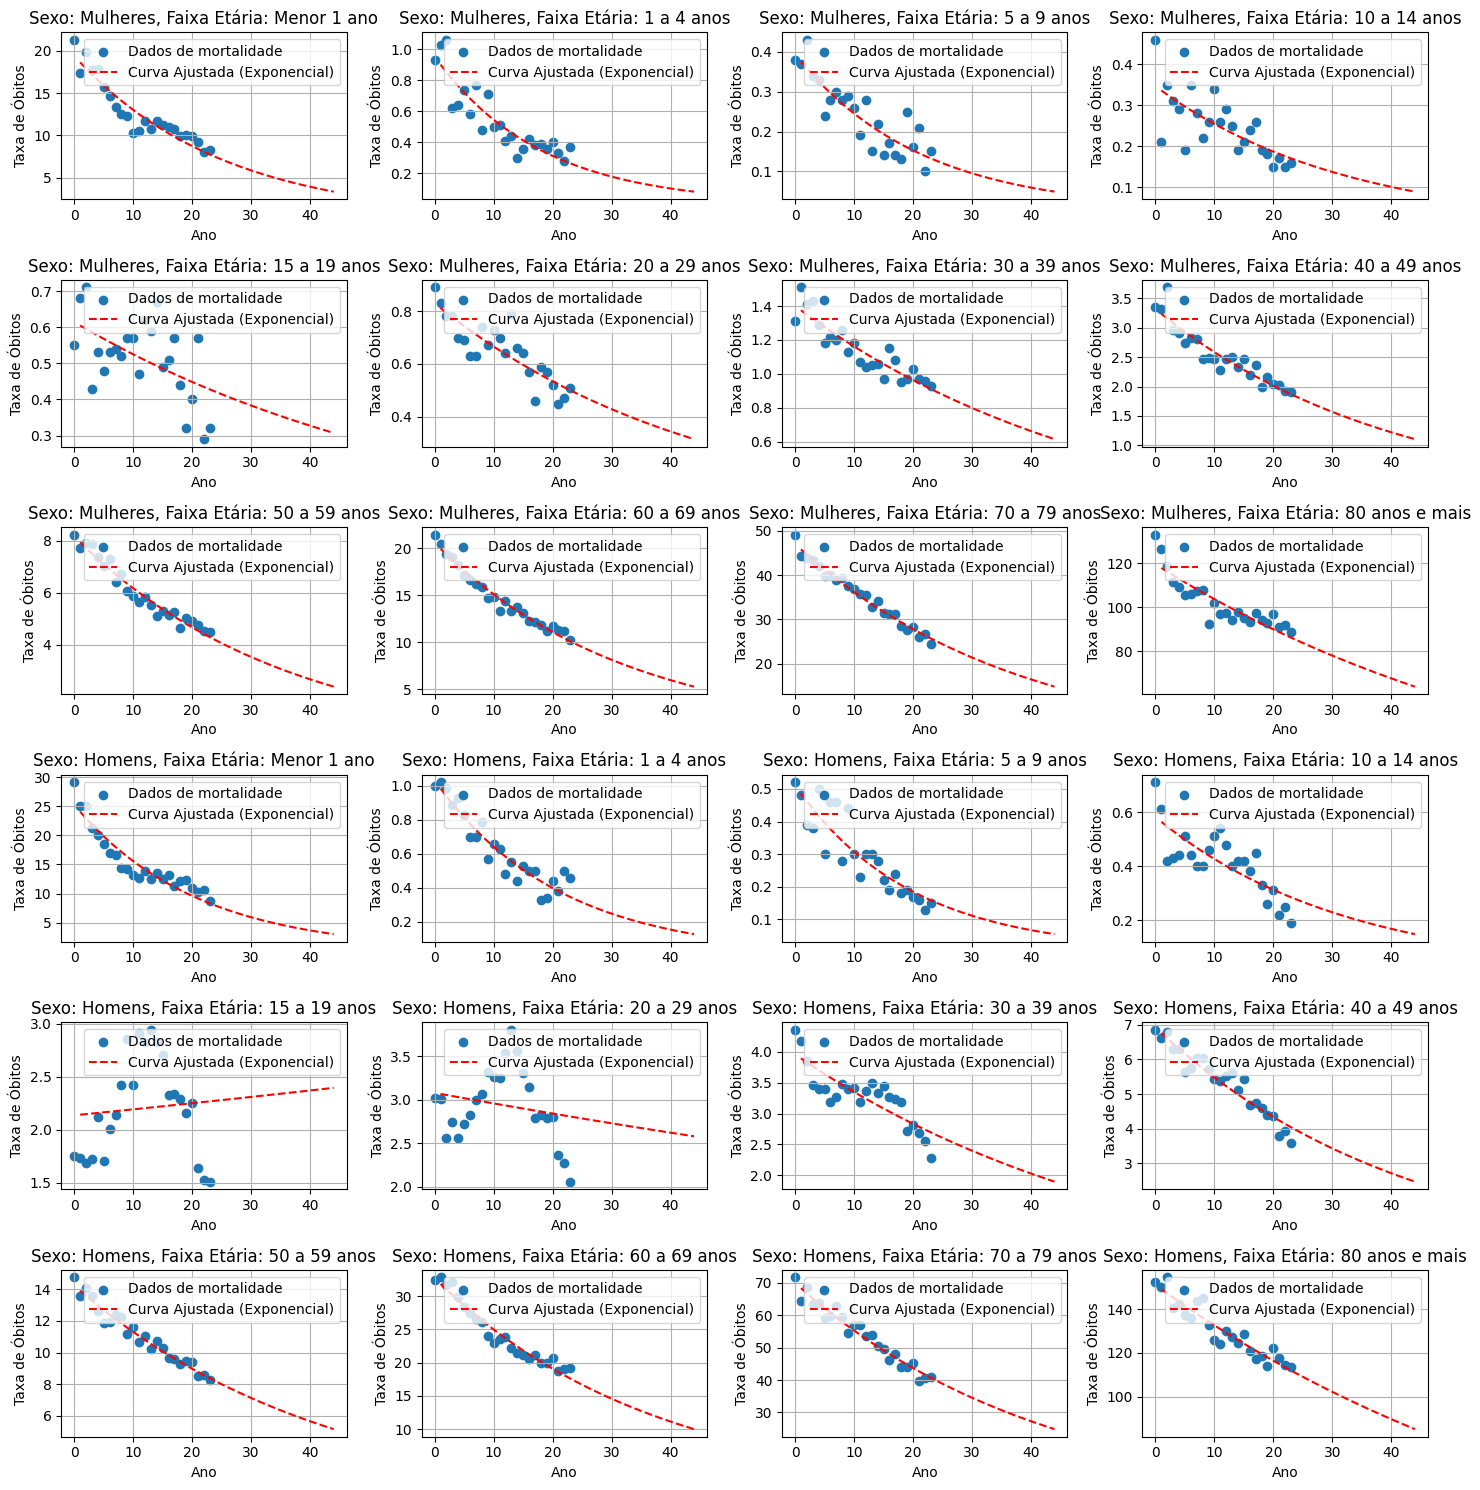

In [124]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from itertools import product

# Função para o modelo exponencial decrescente
def modelo_exponencial(x, constante, coeficiente):
    return constante * np.exp(coeficiente * (-x - 1))

# DataFrame de resultados
resultados = pd.DataFrame(columns=['Sexo', 'Faixa Etária', 'Constante', 'Coeficiente'])

# Combinações de sexo e faixa etária
sexos = df_mortalidade['Sexo'].unique()
faixas_etarias = df_mortalidade['Faixa Etária'].unique()
num_plots = len(sexos) * len(faixas_etarias)
num_colunas = 4
num_linhas = (num_plots + num_colunas - 1) // num_colunas

# Criar subplots para cada combinação de sexo e faixa etária
fig, axs = plt.subplots(num_linhas, num_colunas, figsize=(15, 15))
fig.subplots_adjust(wspace=0.5, hspace=0.5)

for i, (sexo, faixa_etaria) in enumerate(product(sexos, faixas_etarias)):
    if i >= num_plots:
        break  # Sair se todos os subplots já estiverem preenchidos
    
    # Filtrar o DataFrame para a combinação atual
    df_filtro = df_mortalidade[(df_mortalidade['Sexo'] == sexo) & (df_mortalidade['Faixa Etária'] == faixa_etaria)]
    
    # Extrair os dados de anos e mortalidade
    anos = np.array(df_filtro.columns[2:], dtype=int) - 1996
    dados_mortalidade = df_filtro.iloc[0, 2:].values.astype(float)
    
    # Ajustar o modelo exponencial aos dados
    try:
        params, _ = curve_fit(modelo_exponencial, anos, dados_mortalidade, maxfev=10000)
        constante, coeficiente = params
    except RuntimeError:
        constante, coeficiente = np.nan, np.nan
    
    # Criar um DataFrame temporário com os resultados atuais
    df_temp = pd.DataFrame({'Sexo': [sexo], 'Faixa Etária': [faixa_etaria],
                            'Constante': [constante], 'Coeficiente': [coeficiente]})
    
    # Concatenar o DataFrame temporário ao DataFrame de resultados
    resultados = pd.concat([resultados, df_temp], ignore_index=True)

    # Calcular as previsões do modelo para os anos futuros
    anos_futuros = np.arange(1, 45)
    previsao = modelo_exponencial(anos_futuros, constante, coeficiente)
    
    # Plotar os dados originais e a curva ajustada
    row, col = divmod(i, num_colunas)
    axs[row, col].scatter(anos, dados_mortalidade, label='Dados de mortalidade', marker='o')
    axs[row, col].plot(anos_futuros, previsao, label='Curva Ajustada (Exponencial)', linestyle='--', color='red')
    axs[row, col].set_xlabel('Ano')
    axs[row, col].set_ylabel('Taxa de Óbitos')
    axs[row, col].set_title(f'Sexo: {sexo}, Faixa Etária: {faixa_etaria}')
    axs[row, col].legend()
    axs[row, col].grid(True)

# Exibir os subplots
plt.tight_layout()
plt.show()
